In [2]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

# Probamos primero con nuestros datos sin modificar, codificados.

In [3]:
df = pd.read_csv('data/df_encoding.csv', index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,charges_Sklearn,age_robust,bmi_robust,children_robust,smoker_map,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0.472641,-0.80,-0.228803,-0.5,1,1,0,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0.018101,-0.84,0.503117,0.0,0,0,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0.099775,-0.44,0.407107,1.0,0,0,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0.625547,-0.24,-0.876559,-0.5,0,0,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0.082306,-0.28,-0.106608,-0.5,0,0,1,0,1,0,0


In [4]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'charges_Sklearn', 'age_robust', 'bmi_robust', 'children_robust',
       'smoker_map', 'sex_female', 'sex_male', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [6]:
df = df.drop(['charges_Sklearn', 'age_robust', 'bmi_robust', 'children_robust', 'smoker', 'region','sex', 'sex_female', 'sex_male', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],axis=1)

In [7]:
df.columns

Index(['age', 'bmi', 'children', 'charges', 'smoker_map'], dtype='object')

In [8]:
X = df.drop("charges", axis = 1)  #Separamos nuestros datos
y = df["charges"]

In [9]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
param = {"max_depth": [5,7,9,12], # Reducimos la profundidad  siguiendo el modelo del pair anterior.
        "max_features": [1,2],
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [11]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [12]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 7, 9, 12], 'max_features': [1, 2],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [13]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=7, max_features=2, min_samples_leaf=10,
                      min_samples_split=10)

In [14]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [15]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [37]:
dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest - datos originales")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,2536.954790,2.215274e+07,4706.669594,0.588181,test,Random Forest - datos originales
1,2282.453299,1.621352e+07,4026.601489,0.687911,train,Random Forest - datos originales


In [17]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,smoker_map,0.542445
0,age,0.357797
1,bmi,0.070538
2,children,0.029220


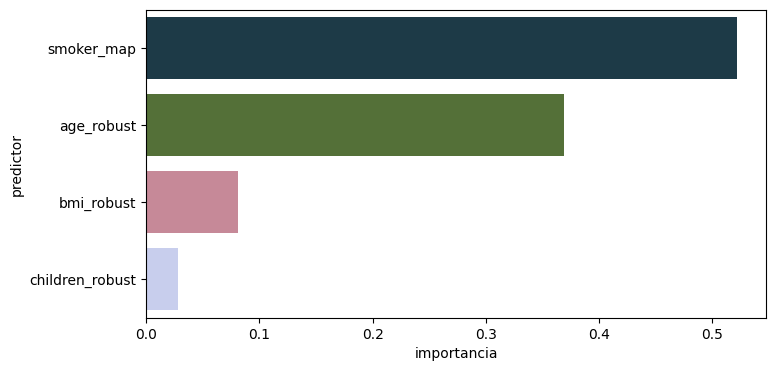

In [50]:
plt.figure(figsize=(8,4))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="cubehelix" );
plt.show()

## Lo hacemos igual para el DF normalizado

In [19]:
df3 = pd.read_csv("data/df_encoding.csv", index_col = 0)
df3.head()


,age,sex,bmi,children,smoker,region,charges,charges_Sklearn,age_robust,bmi_robust,children_robust,smoker_map,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0.472641,-0.80,-0.228803,-0.5,1,1,0,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0.018101,-0.84,0.503117,0.0,0,0,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0.099775,-0.44,0.407107,1.0,0,0,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0.625547,-0.24,-0.876559,-0.5,0,0,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0.082306,-0.28,-0.106608,-0.5,0,0,1,0,1,0,0


In [20]:
df3 = df3.drop(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'sex', 'sex_female', 'sex_male', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'], axis=1)


In [21]:
df3.columns

Index(['charges_Sklearn', 'age_robust', 'bmi_robust', 'children_robust',
       'smoker_map'],
      dtype='object')

In [26]:
X1 = df3.drop("charges_Sklearn", axis = 1)
y1 = df3["charges_Sklearn"]

In [27]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

Aplicamos los mismos parámetros que en el anterior modelo, los heredados del decision tree.

In [30]:
gs_rf.fit(x1_train, y1_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 7, 9, 12], 'max_features': [1, 2],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [31]:
bosque2 = gs_rf.best_estimator_
bosque2

RandomForestRegressor(max_depth=7, max_features=2, min_samples_leaf=10,
                      min_samples_split=10)

In [32]:
y1_pred_test_rf = bosque2.predict(x1_test)
y1_pred_train_rf = bosque2.predict(x1_train)

In [33]:
dt_results2 = metricas(y1_test, y1_train, y1_pred_test_rf, y1_pred_train_rf, "Random Forest -datos normalizados")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.077184,0.019696,0.140341,0.592749,test,Random Forest -datos normalizados
1,0.068956,0.014465,0.120269,0.690313,train,Random Forest -datos normalizados


In [39]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x1_train.columns,
                             'importancia': bosque2.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,smoker_map,0.521836
0,age_robust,0.369268
1,bmi_robust,0.081118
2,children_robust,0.027778


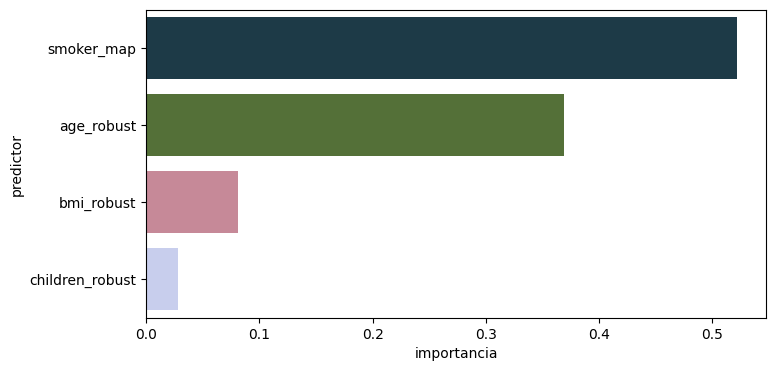

In [51]:
plt.figure(figsize=(8,4))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="cubehelix" );
plt.show()

Tras visualizar las dos gráficas en las que se representa la importancia de las variables, comprobamos que en ambos modelos la que más peso tiene es la variable smoker seguida de la de age. Y en ambos casos con cifras similares, 0.5 y 0.4, respectivamente.

In [47]:
df_comparado= pd.concat ([dt_results, dt_results2], axis=0)
df_comparado

,MAE,MSE,RMSE,R2,set,modelo
0,2536.954790,2.215274e+07,4706.669594,0.588181,test,Random Forest - datos originales
1,2282.453299,1.621352e+07,4026.601489,0.687911,train,Random Forest - datos originales
0,0.077184,1.969551e-02,0.140341,0.592749,test,Random Forest -datos normalizados
1,0.068956,1.446457e-02,0.120269,0.690313,train,Random Forest -datos normalizados


Después de esta comparativa, vemos que apenas hay diferencias entre ambos modelos ya que las métricas son muy parecidas, de hecho, el r2 es casi identico. En los dos modelos, se aprecia un ligero overfitting ya que los resultados del train son un poco mejores que los del test.

In [52]:
df_comparado.to_csv('data/df_RF_comparado.csv')